# The curse: dealing with high-dimensional data [2]

In the [first post](curse1.ipynb), I showed that a nearest-neighbour classifier does not perform well on the Dot-and-Shell example with a large number of dimensions. In this second post, we continue with the Dot-and-Shell example and check whether knowledge-based feature engineering can help.

Let's load the packages we need first:

In [1]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree as BallTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
random.seed(11)

## Knowledge-based feature engineering

Since we know how the data were simulated, we can use this knowledge to generate a feature, in the hopes that this feature provides sufficient information to differentiate between the two classes. One such feature is the distance from a point to the origin. The next figure show results for the 2D, 3D, and 42D case from top to bottom. The left panels shows the first two coordinates of the data points. The right panels show the computed feature, i.e. the distance from every point to the origin, each time as a function of their sample number (within the class). In all three cases, this distance feature easily allows to separate the two classes.

In [2]:
M = 1024
r0 =0
r1 =1

def fDataGeneration(M,N,R):
    X = np.random.normal(0,1,[M,N])
    X = np.divide(X,np.sqrt(np.sum(X**2,axis=1)[:,None]))
    xConv = False
    counter=0
    while (counter<11 and xConv==False):
        counter += 1
        U = (R**N+((R+1/2)**N-R**N)*np.random.uniform(0,1,[M,1]))**(1/float(N))
        if ~np.any(np.isnan(U.flatten())):
            xConv = True
            Y = X*U
            pass
        else:
            print(counter)
        
    return Y


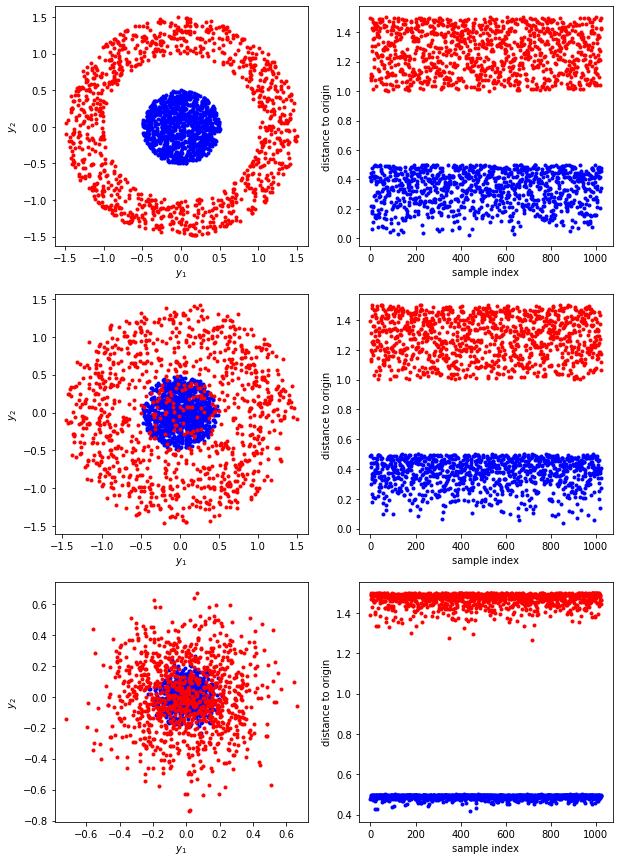

In [3]:
fig,ax = plt.subplots(nrows=3, ncols=2,figsize=[10,15])

for row,N in enumerate([2,3,42]):
    Y0 = fDataGeneration(M,N,R=r0)
    Y1 = fDataGeneration(M,N,R=r1)

    R0 = np.linalg.norm(Y0,axis=1)
    R1 = np.linalg.norm(Y1,axis=1)

    ax[row,0].plot(Y0[:,0],Y0[:,1],'b.')
    ax[row,0].plot(Y1[:,0],Y1[:,1],'r.')
    ax[row,1].plot(R0,'b.')
    ax[row,1].plot(R1,'r.')
    
    ax[row,0].set_xlabel('$y_1$');
    ax[row,0].set_ylabel('$y_2$');
    ax[row,1].set_xlabel('sample index');
    ax[row,1].set_ylabel('distance to origin');
    

## Lifting the curse of dimensionality
To see whether the computed feature is effective to combat the curse of dimensionality, we build 1-NN classifiers that take the computed feature as an input (and nothing else). So the original classification problem with $N$ inputs is turned into a classification problem with 1 input by means of knowledge-based feature engineering. This time, I let $N$ run from 2 to 500. The next figure shows the results. The classification performances (top panel) are excellent: the 1-NN classifiers deliver perfect classification regardless of the dimension. The middle panel shows the within-class distance to the nearest neigbor. This distance, i.e. the difference between neighboring values of the computed feature, decreases towards zero for both classes. In contrast, the out-of-class distances to the nearest neighbor increase with large dimensions and seem to stabilize around a value of 1 for both classes.

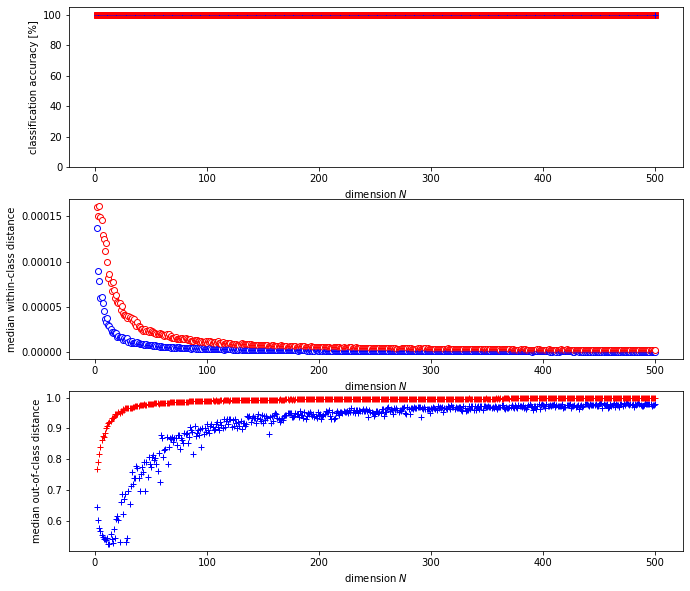

In [4]:
#%matplotlib notebook
Nmax=500

fig,ax = plt.subplots(nrows=3, ncols=1,figsize=[11,10])

for N in np.arange(2,Nmax+1):
    #print('Dimension: '+str(N))
    Y0 = fDataGeneration(M,N,R=r0)
    Y1 = fDataGeneration(M,N,R=r1)
    R0 = np.linalg.norm(Y0,axis=1)
    R1 = np.linalg.norm(Y1,axis=1)

    BT0 = BallTree(R0[:,None], leaf_size=5, p=2)
    BT1 = BallTree(R1[:,None], leaf_size=5, p=2)
    
    nn_dist00 =np.sort(BT0.query(R0[:,None], 2)[0][:, 1])
    nn_dist11 =np.sort(BT1.query(R1[:,None], 2)[0][:, 1])
    nn_dist10 =np.sort(BT0.query(R1[:,None], 2)[0][:, 0])
    nn_dist01 =np.sort(BT1.query(R0[:,None], 2)[0][:, 0])
    
    ax[1].plot(N,np.median(nn_dist00), 'bo',markerfacecolor='w')
    ax[1].plot(N,np.median(nn_dist11), 'ro',markerfacecolor='w')
    ax[2].plot(N,np.median(nn_dist01), 'b+')
    ax[2].plot(N,np.median(nn_dist10), 'r+')
    
    F0 = np.sum((nn_dist00<nn_dist01)*1.0)/M
    F1 = np.sum((nn_dist11<nn_dist10)*1.0)/M
    ax[0].plot(N,F1*100, 'rs')
    ax[0].plot(N,F0*100, 'b+')
    
ax[0].set_xlabel('dimension $N$');
ax[0].set_ylabel('classification accuracy [%]');
ax[0].set_ylim([0,105]);
ax[1].set_xlabel('dimension $N$');
ax[1].set_ylabel('median within-class distance');
ax[2].set_xlabel('dimension $N$');
ax[2].set_ylabel('median out-of-class distance');

plt.show()
    

## Take home message

In this post I showed how one can compute a useful feature based on knowledge from the data-generating distributions. The conclusions should not be too surprising for well-weathered data mining specialists:

* Computing good features helps building good classifiers

* In the example, the computed feature helps lifting the curse of dimensionality, essentially by reducing the high-dimensional data to a single feature that is - by design - very informative about the class membership.

Feature engineering based on knowledge about the data-generating process is crucial for many machine learning applications. However, doing so in a simulated example certainly feels like cheating. The next question is therefore whether we can expect to build any good machine learning model to do this kind of feature engineering for us. This is certainly relevant as we might not always have domain expertise to guide us in the formulation of an informative feature.